In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.notebook import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

import re
import contractions

In [3]:
from flair.data import Sentence
from flair.nn import Classifier

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

import demoji
from detoxify import Detoxify
from better_profanity import profanity

from nsfw_detector import predict
from nudenet import NudeDetector

In [5]:
import nltk
nltk.download('vader_lexicon') # Not with Jio Network
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
import spacy
from spacy.tokens import DocBin
import en_core_web_lg

In [7]:
sentiment = SentimentIntensityAnalyzer()
tagger = Classifier.load('sentiment')

In [8]:
def get_sentiment(text):
    print("\nText:", text)
    
    text = " ".join(text.splitlines())
    sent = sentiment.polarity_scores(text)
    print("\nSentiment: ", sent, "\n")
    
    sentence = Sentence(text)
    tagger.predict(sentence)
    print("\nSentiment: ", sentence)

In [9]:
def get_spam(text):
    model = pickle.load(open(r".\models\spam_lr_model.pkl", 'rb'))
    vect = pickle.load(open(r".\models\spam_vectorizer.pkl", 'rb'))
    sen = [text]
    sen_trans = vect.transform(sen)
    p = model.predict(sen_trans)[0]
    prob = model.predict_proba(sen_trans)[0]
    validity = ["ham","spam"]
    print(sen[0], validity[p], sep='\n')
    print(prob)

In [10]:
def get_hate(text):
    model = pickle.load(open(r".\models\hate_lr_model.pkl", 'rb'))
    vect = pickle.load(open(r".\models\hate_vectorizer.pkl", 'rb'))
    sen = [text]
    sen_trans = vect.transform(sen)
    p = model.predict(sen_trans)[0]
    prob = model.predict_proba(sen_trans)[0]
    validity = ["allowed","toxic"]
    print(validity[p])
    print(prob)

In [11]:
def get_abuse(text):
    model = pickle.load(open(r".\models\abuse_lr_model.pkl", 'rb'))
    vect = pickle.load(open(r".\models\abuse_vectorizer.pkl", 'rb'))
    sen = [text]
    sen_trans = vect.transform(sen)
    p = model.predict(sen_trans)[0]
    prob = model.predict_proba(sen_trans)[0]
    validity = ["allowed","abuse"]
    print(validity[p])
    print(prob)

In [12]:
det = Detoxify('unbiased')

def get_detox(text):
    print(text)
    text = " ".join(text.splitlines())
    toxicity = det.predict(text)
    toxicity = {k: round(v, 3) for k, v in toxicity.items()}
    print(toxicity, "\n")

In [13]:
def get_profanity(text):
    print(text)
    censored = profanity.censor(text)
    print(censored)
    profanity_model = pickle.load(open(r".\models\Profanity_cust.pkl", 'rb'))
    censored = profanity_model.censor(text)
    # print(censored)
    bwset = pickle.load(open(r".\models\bwset.pkl","rb"))
    for i in censored.split():
        if i in bwset:
            censored.replace(i, '*'*len(i))
    print(censored)

In [14]:
nlp_cus_ner = spacy.load("./models/model-best")
def get_ner(text):
    doc = nlp_cus_ner(text)
    for token in doc.ents:
        print(token.text,token.label_)
    spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

In [15]:
model = predict.load_model(r'.\models\nsfw_mobilenet2.224x224.h5')
detector = NudeDetector() 

In [16]:
def nsfw(img_path, new_path):
    img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    print(predict.classify(model, img_path))
    print(detector.detect(img_path))
    detector.censor(img_path, output_path=new_path)
    Out_Image = cv2.cvtColor(cv2.imread(new_path), cv2.COLOR_BGR2RGB)
    plt.imshow(Out_Image)

In [17]:
def violence(img_path):
    model = pickle.load(open(r".\models\violence_resnetmain.pkl","rb"))
    checkpoint = torch.load(r".\models\main_model.pt")

    standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    print(model.load_state_dict(checkpoint['state_dict']))
    class_names = ['safe', 'unsafe']
    print(class_names)
    
    def load_input_image(img_path):    
        image = Image.open(img_path).convert('RGB')
        prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                         transforms.ToTensor(), 
                                         standard_normalization])

        # discard the transparent, alpha channel (that's the :3) and add the batch dimension
        image = prediction_transform(image)[:3,:,:].unsqueeze(0)
        return image

    def predict_image(model, class_names, img_path):
        # load the image and return the predicted breed
        img = load_input_image(img_path)
        model = model.cpu()
        model.eval()
        idx = torch.argmax(model(img))
        return class_names[idx]

    def run_app(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        prediction = predict_image(model, class_names, img_path)
        return prediction
    
    print(run_app(img_path))

In [36]:
get_sentiment("I love the new features in the latest update!")


Text: I love the new features in the latest update!

Sentiment:  {'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.6696} 


Sentiment:  Sentence[10]: "I love the new features in the latest update!" → POSITIVE (0.9914)


In [37]:
get_spam("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
spam
[0.12539726 0.87460274]


In [51]:
get_hate("its common sense moron, it was a fight in the wec")

allowed
[0.54124396 0.45875604]


In [39]:
get_abuse("its common sense moron, it was a fight in the wec")

abuse
[0.22491302 0.77508698]


In [40]:
get_detox("its common sense moron, it was a fight in the wec")

its common sense moron, it was a fight in the wec
{'toxicity': 0.989, 'severe_toxicity': 0.0, 'obscene': 0.013, 'identity_attack': 0.001, 'insult': 0.982, 'threat': 0.0, 'sexual_explicit': 0.0} 



In [41]:
get_profanity("its common sense moron, it was a fight in the wec b1tchy ")

its common sense moron, it was a fight in the wec b1tchy 
its common sense ****, it was a fight in the wec b1tchy 
its common sense ****, it was a fight in the wec **** 


In [42]:
get_ner("""No, you are the racist, you goddamn neo-Nazi    YOU BIG BOY
I had enough of you, bastard.
Alyssaa oconnor is reatrded
Hey I'm just tellin' like it is you ugly as fuck butt fugly muthafucka!
You ignoramus! My cousin just did the hitler pictures and the swastikas and what not. 
I've been the one talking to you you imbecile. I can't believe that people that are stupid like you exist.
It makes we want to start playing russian roulette with myself.""")

racist INSULT
neo-Nazi INSULT
bastard. ABUSIVE
ugly INSULT
fuck ABUSIVE
butt ABUSIVE
fugly ABUSIVE
muthafucka ABUSIVE
swastikas SUGGESTIVE
imbecile INSULT


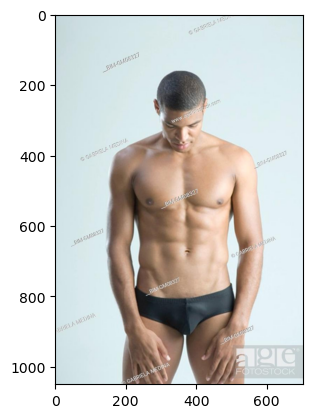

C:\Users\PARTHA\Downloads\Partha\Content Moderation System\nsam.jpg size: (224, 224)
1/1 [==============================] - 2s 2s/step
{'C:\\Users\\PARTHA\\Downloads\\Partha\\Content Moderation System\\nsam.jpg': {'drawings': 0.004491335246711969, 'hentai': 0.003503353800624609, 'neutral': 0.06630111485719681, 'porn': 0.07643216848373413, 'sexy': 0.8492720127105713}}
[{'class': 'BELLY_EXPOSED', 'score': 0.817872166633606, 'box': [273, 587, 199, 187]}, {'class': 'MALE_BREAST_EXPOSED', 'score': 0.7806234359741211, 'box': [220, 461, 152, 106]}, {'class': 'MALE_BREAST_EXPOSED', 'score': 0.7279748916625977, 'box': [373, 462, 143, 100]}, {'class': 'FEMALE_GENITALIA_COVERED', 'score': 0.7246785163879395, 'box': [321, 835, 98, 94]}, {'class': 'FACE_MALE', 'score': 0.6580422520637512, 'box': [304, 281, 122, 112]}, {'class': 'ARMPITS_EXPOSED', 'score': 0.593158483505249, 'box': [493, 444, 46, 73]}]


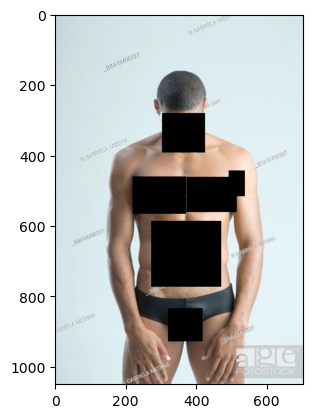

In [18]:
nsfw(r"C:\Users\PARTHA\Downloads\Partha\Content Moderation System\nsam.jpg", "./output/censored.png")

<All keys matched successfully>
['safe', 'unsafe']


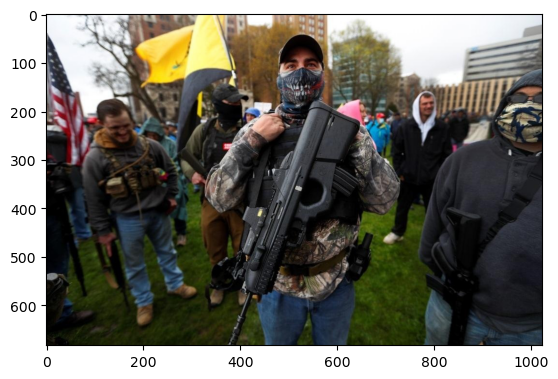

unsafe


In [34]:
violence(r"C:\Users\PARTHA\Downloads\Partha\Content Moderation System\sample2.jpg")